# DTSA 5511 - Intro to Deep Learning

## Building a Customer Service Router for Outdoor Gear Retail


## Introduction

##Overview

In this project, we will aim to develop a customer service routing system that will aid outdoor gear and apparel customer questions to route text inquiries into three distinct categories. This classification system could be implemented as a tool for an online outdoor gear customer service tean to more efficiently route customer questions to specific individuals with knowledge on the topic. The tool would be able to streamline the following:

1.   Reducing response time through automatic routing
2.   Ensuring consistent handling of common inquiry types
3.   Allowing customer service representatives to focus on complex cases

This project will utilize deep learning, specifically a Bidirectional Long Short-Term Memory (BiLSTM) neural network architecture with attention mechanisms to classify customer inquiries into three distinct categories.

###The Data

To train the BiLSTM model, we will be using the Amazon Sports & Outdoors product dataset. This dataset contains product reviews and metadata from Amazon including 12.8 million reviews from May 1996 -> July 2014. While the dataset wasn't originally designed for customer service applications, the customer insights included is very valuable to train a BiLSTM model for a project such as this. The dataset includes reviews including rating specific columns (text, a helpfulnes score, etc.) and product columns (descriptions, category info, price, brand, image features, etc.).


###Intent Classification System


The model that will be developed in this notebook will aim to accurately categorize customer questions into three categories:

1.   Sizing Questions (fit guidance, size comparisons)
2.   Technical Specifications (material properties, product features)
3.   Product Recommendations (=gear suggestions based on use case)

There will also be a catch all 'other' category.

###Technical Implementation

From a technical perspective a BiLSTM architecture model will be built and trained with bi-directional processing, attention mechanisms that will provide greater weight to critial parts of a customer quesion, word embeddings to capture semantic relationships.

Here is a step by step overview to on how the BiLSTM classifier will be implemented.


###Input Processing


Customer inquiries are tokenized and converted into word embeddings. Then these sequences are standardized.


###Core Architecture


The Bidirectional LSTM layers will process text in both a forward and backward manner. Attention mechanisms will achieve to identify key phrases. Dropout layers will attempt to prevent overfitting. Dense layers will map to the final classifications.

This system will serve as an automated customer service routing system with the ability for potential expansion and implementation to a online outdoor gear platform.

## Imports

In [1]:
# general imports
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import time
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# torch specific imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F

# nltk specific imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# mounting our Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [5]:
# the original dataset is massive (3.2 million rows), even limiting to only the sports and outdoors category
# here I am sampling the data down to 750000 rows to keep the training and pre-processing time down
# in this example, I am sampling based on a random number generator
def parse_and_sample(path, n_samples = 750000, random_seed = 420):
    random.seed(random_seed)
    data = []
    count = 0

    with gzip.open(path, 'rb') as g:
        for line in g:
            if count < n_samples or random.random() < n_samples / float(count + 1):
                try:
                    parsed_line = eval(line)
                    if count < n_samples:
                        data.append(parsed_line)
                    else:
                        replace_idx = random.randint(0, n_samples - 1)
                        data[replace_idx] = parsed_line
                except:
                    continue

            count += 1
            if count % 100000 == 0:
                print(f"Processed {count} rows...")

    print(f"Finished processing {count} total rows")
    return pd.DataFrame(data)

In [6]:
# passing along our sports and outdoors dataset to the function above
df_sampled = parse_and_sample('/content/drive/MyDrive/DTSA 5511 - Intro to Deep Learning/reviews_Sports_and_Outdoors.json.gz', n_samples=750000)

Processed 100000 rows...
Processed 200000 rows...
Processed 300000 rows...
Processed 400000 rows...
Processed 500000 rows...
Processed 600000 rows...
Processed 700000 rows...
Processed 800000 rows...
Processed 900000 rows...
Processed 1000000 rows...
Processed 1100000 rows...
Processed 1200000 rows...
Processed 1300000 rows...
Processed 1400000 rows...
Processed 1500000 rows...
Processed 1600000 rows...
Processed 1700000 rows...
Processed 1800000 rows...
Processed 1900000 rows...
Processed 2000000 rows...
Processed 2100000 rows...
Processed 2200000 rows...
Processed 2300000 rows...
Processed 2400000 rows...
Processed 2500000 rows...
Processed 2600000 rows...
Processed 2700000 rows...
Processed 2800000 rows...
Processed 2900000 rows...
Processed 3000000 rows...
Processed 3100000 rows...
Processed 3200000 rows...
Finished processing 3268695 total rows


### Intent

In [7]:
def clean_text(text):
    """
    this function cleans and normalizes our text by converting to lowercase, removing special characters, and extra whitespace

    args:
        - text: text string
    returns:
        - cleaned text string
    """
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
def preprocess_reviews(df):
    """
    this function preprocesses the dataset. It will:
        - create a 'full_text' col that will combine the summary of the review and the review itself
        - create a 'cleaned_text' col that will apply the clean_text function previously defined
        - remove any empty reviews
        - remove any duplicate reviews

    args:
        - df: review dataframe
    returns:
        - preprocessed review dataframe
    """
    df_processed = df_sampled.copy()
    df_processed['full_text'] = df_processed['summary'] + ' ' + df_processed['reviewText']
    df_processed['cleaned_text'] = df_processed['full_text'].fillna('').apply(clean_text)
    df_processed = df_processed[df_processed['cleaned_text'].str.len() > 0]
    df_processed = df_processed.drop_duplicates(subset = ['cleaned_text'])
    return df_processed

In [9]:
df_processed = preprocess_reviews(df_sampled)

In [10]:
def assign_intent_labels(text):
    """
    this function assigns intent labels based on the content of the cleaned text
    the labels are:
        0: sizing questions
        1: technical specs
        2: product recommendations
        3: other
    """
    text = text.lower()

    # category keywords
    sizing_keywords = [
        # basic sizes
        'size', 'sized', 'sizing',
        'fit', 'fits', 'fitted', 'fitting',
        'length', 'width', 'height',

        # size categories
        'small', 'medium', 'large', 'xl', 'xxl', 'xs',
        'petite', 'plus', 'regular', 'tall', 'short',

        # fit descriptions
        'tight', 'loose', 'snug', 'baggy', 'roomy',
        'oversized', 'undersized', 'bigger', 'smaller',
        'comfortable', 'uncomfortable', 'comfy',

        # measurements relating to sizes
        'measurement', 'measurements',
        'waist', 'chest', 'hip', 'shoulder',
        'sleeve', 'inseam', 'bust', 'thigh',
        'dimension', 'dimensions',

        # size phrases
        'runs small', 'runs large', 'runs big',
        'true to size', 'tts',
        'how does it fit', 'what size',
        'size up', 'size down',
        'wear', 'wearing'
    ]

    tech_keywords = [
        # tech materials
        'material', 'fabric', 'textile', 'leather',
        'cotton', 'polyester', 'wool', 'nylon',
        'spandex', 'elastic', 'synthetic', 'mesh',
        'lining', 'canvas', 'rubber', 'suede',
        'construction', 'made of', 'composition',

        # tech features
        'waterproof', 'water-resistant', 'breathable',
        'moisture-wicking', 'weatherproof', 'windproof',
        'insulated', 'thermal', 'ventilated',
        'reinforced', 'padded', 'cushioned',
        'durable', 'lightweight', 'heavy-duty',

        # tech specs
        'specification', 'specs', 'features',
        'weight', 'capacity', 'volume',
        'temperature', 'rating', 'performance',
        'technology', 'technical', 'durability',

        # tech components
        'zipper', 'pocket', 'strap', 'closure',
        'seam', 'stitching', 'sole', 'hood',
        'button', 'velcro', 'drawstring',

        # tech performance
        'quality', 'performance', 'function',
        'design', 'protection', 'support',
        'comfort', 'grip', 'traction',
        'flexibility', 'strength', 'structure'
    ]

    recommendation_keywords = [
        # recommendation words
        'recommend', 'recommendation', 'recommended',
        'suggest', 'suggestion', 'suggested',
        'advice', 'advise', 'guidance',

        # comparison terms
        'best', 'better', 'worse', 'worst',
        'alternative', 'alternatives',
        'similar', 'different', 'comparable',
        'versus', 'vs', 'compare',
        'preference', 'preferred',

        # intent
        'looking for', 'searching for', 'need',
        'want', 'considering', 'thinking about',
        'choose', 'deciding', 'decision',
        'option', 'options', 'choice', 'choices',

        # suitability
        'good for', 'suitable for', 'appropriate for',
        'work for', 'ideal for', 'perfect for',
        'worth it', 'worth the',

        # use case words
        'use case', 'purpose', 'activity',
        'occasion', 'situation', 'scenario',
        'when should', 'where should',

        # opinion words
        'opinion', 'thoughts', 'experience',
        'feedback', 'review', 'insight',
        'what do you think', 'would you',
        'should i', 'do you recommend'
    ]

    if any(keyword in text for keyword in sizing_keywords):
        return 0
    elif any(keyword in text for keyword in tech_keywords):
        return 1
    elif any(keyword in text for keyword in recommendation_keywords):
        return 2
    else:
        return 3

In [11]:
# applying labels to cleaned text
df_processed['intent_label'] = df_processed['cleaned_text'].apply(assign_intent_labels)

In [12]:
# checking the count of each intent label
# the distribution is pretty good here, this will help out model during training
df_processed['intent_label'].value_counts()

,count
intent_label,
0,386388
3,132465
1,122783
2,107155


With some basic EDA completed, we can now move on to building our model. We will be implementing a BiLSTM classification model. It's goal will be to classify which category the reivew belongs to. Our classification labels will be:

*   sizing
*   technical specs
*   product recommendations
*   other (catch all bucket for questions that do not fall into any of the other 3 categories)



In [13]:
def tokenize_text(text):
    """
    tokenize the text and remove any nltk stopwords

    args:
        - text: input text
    returns:
        - tokens in list form
    """
    # using nltk's word_tokenize
    tokens = word_tokenize(text)

    # removing stopwords from nltk's stopwords list
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [14]:
# to begin our BiLSTM framework, we need to convert our text to numerical inputs
# as neural networds cannot process text directly. We will use the following function
# to create a mapping for each unique word. We will also include a maximum number
# of unique words the model will need to handle and will remove words that come up
# less than a certain number of times.
def create_vocabulary(texts, max_vocab_size = 10000, min_freq = 2):
    """
    creating a word mapping vocabulary from text

    args:
        - texts: text strings
        - max_vocab_size: max vocab size
        - min_freq: min word frequency
    returns:
        - word2idx: word to index mapping
        - idx2word: inverse index to word mapping
    """
    # first counting the frequency of each word
    word_freq = {}
    for text in texts:
        tokens = tokenize_text(text)
        for token in tokens:
            word_freq[token] = word_freq.get(token, 0) + 1

    # next filtering out rare words and sorting by the number of instances
    word_freq = {k: v for k, v in word_freq.items() if v >= min_freq}
    word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:max_vocab_size - 2])

    # finally creating the mappings with padding
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    word2idx.update({word: idx + 2 for idx, word in enumerate(word_freq.keys())})
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word

In [15]:
def prepare_data_for_training(df_processed, max_seq_length = 200):
    """
    Prepare data for model training including sequence lengths

    Args:
        - df_processed: preprocessed dataframe
        - max_seq_length: max sequence length
    Returns:
        - X_tensor: padded sequence tensor
        - lengths_tensor: sequence lengths tensor
        - word2idx: vocabulary mapping
    """
    # Create vocabulary using the 'cleaned_text'
    word2idx, idx2word = create_vocabulary(df_processed['cleaned_text'])

    # Convert texts to sequences and track lengths
    X = []
    lengths = []

    for text in df_processed['cleaned_text']:
        tokens = tokenize_text(text)
        # Get sequence length before truncation
        length = min(len(tokens), max_seq_length)
        # Convert tokens to indices with truncation
        sequence = [word2idx.get(token, word2idx['<UNK>']) for token in tokens[:max_seq_length]]
        # Pad sequence if necessary
        if len(sequence) < max_seq_length:
            sequence = sequence + [word2idx['<PAD>']] * (max_seq_length - len(sequence))

        X.append(sequence)
        lengths.append(length)

    # Convert to tensors
    X_tensor = torch.tensor(X, dtype=torch.long)
    lengths_tensor = torch.tensor(lengths, dtype=torch.long)

    return X_tensor, lengths_tensor, word2idx

In [16]:
# Updated main function
def main():
    # Preprocessing the data
    # df_processed = preprocess_reviews(df_sampled)

    # Creating sequences and getting lengths
    X_tensor, lengths_tensor, word2idx = prepare_data_for_training(df_processed)

    # Prepare labels
    y_tensor = torch.tensor(df_processed['intent_label'].values)

    # Split indices
    train_idx, val_idx = train_test_split(
        range(len(X_tensor)),
        test_size=0.2,
        random_state=42
    )

    # Create datasets
    train_dataset = TensorDataset(
        X_tensor[train_idx],
        y_tensor[train_idx],
        lengths_tensor[train_idx]
    )

    val_dataset = TensorDataset(
        X_tensor[val_idx],
        y_tensor[val_idx],
        lengths_tensor[val_idx]
    )

    # Create dataloaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return df_processed, train_loader, val_loader, word2idx

In [17]:
# calling our main preprocessing function
df_processed, train_loader, val_loader, word2idx = main()

In [18]:
# taking a look at our processed data
df_processed.head(2)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,full_text,cleaned_text,intent_label
0,A1B2O75PZ5ZC78,B00I7HYXG0,Kurt W. Martinsen,"[0, 0]",This is exactly what I expected to receive whe...,5.0,Exactly what I expected to receive when I orde...,1394668800,"03 13, 2014",Exactly what I expected to receive when I orde...,exactly what i expected to receive when i orde...,3
1,A3UO3IKUOF5XHD,B001PQNI70,KEN F,"[0, 0]",THIS HANDGUN IS ONE THAT NO ONE MAKES A REGULA...,5.0,GOOD FIT FOR A TAURUS 9MM THAT THERE ARE NO HO...,1301961600,"04 5, 2011",GOOD FIT FOR A TAURUS 9MM THAT THERE ARE NO HO...,good fit for a taurus mm that there are no hol...,0


## EDA

Now with our data processed correctly, we can do some explatory data analysis to more deeply understand what our data captures

In [ ]:
# creating additional columns we will visualize below:
    # text_length: the number of characters in the cleaned review
    # word_count: the number of words in the cleaned review
    # helpful_ratio: understanding how helpful a particular review was to other shoppers
    # reveiw_datetime: creating a pandas datetime col of when the review happened
    # review_year: getting the year of when the review happened from review_datetime
df_processed['text_length'] = df_processed['cleaned_text'].str.len()
df_processed['word_count'] = df_processed['cleaned_text'].str.split().str.len()
df_processed['helpful_ratio'] = df_processed['helpful'].apply(lambda x: x[0] / x[1] if x[1] > 0 else 0)
df_processed['review_datetime'] = pd.to_datetime(df_processed['reviewTime'])
df_processed['review_year'] = df_processed['review_datetime'].dt.year

In [ ]:
# here is a table showcasing the distribution of the number of words in the cleaned reviews
# and how helpful a particular review was to other shoppers
print(df_processed.groupby('overall')['word_count'].describe())
print(' ')
print(df_processed.groupby('overall')['helpful_ratio'].mean())

            count       mean        std  min   25%   50%   75%     max
overall                                                               
1.0       56975.0  75.756806  77.491676  1.0  32.0  52.0  91.0  3118.0
2.0       38567.0  81.921928  84.753638  2.0  34.0  56.0  98.0  3187.0
3.0       63724.0  80.636730  88.333822  1.0  33.0  53.0  94.0  2349.0
4.0      147169.0  79.364098  92.873175  2.0  31.0  50.0  91.0  3771.0
5.0      442356.0  64.596370  76.990372  1.0  27.0  40.0  72.0  4910.0
 
overall
1.0    0.362550
2.0    0.321379
3.0    0.296465
4.0    0.301213
5.0    0.286365
Name: helpful_ratio, dtype: float64


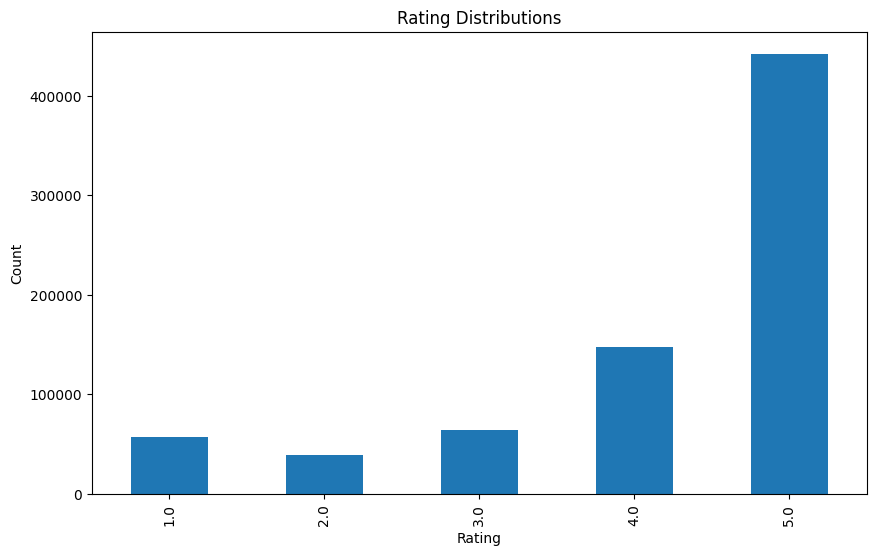

In [ ]:
# bar chart of the distribution of ratings in our dataset
plt.figure(figsize = (10, 6))
df_processed['overall'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

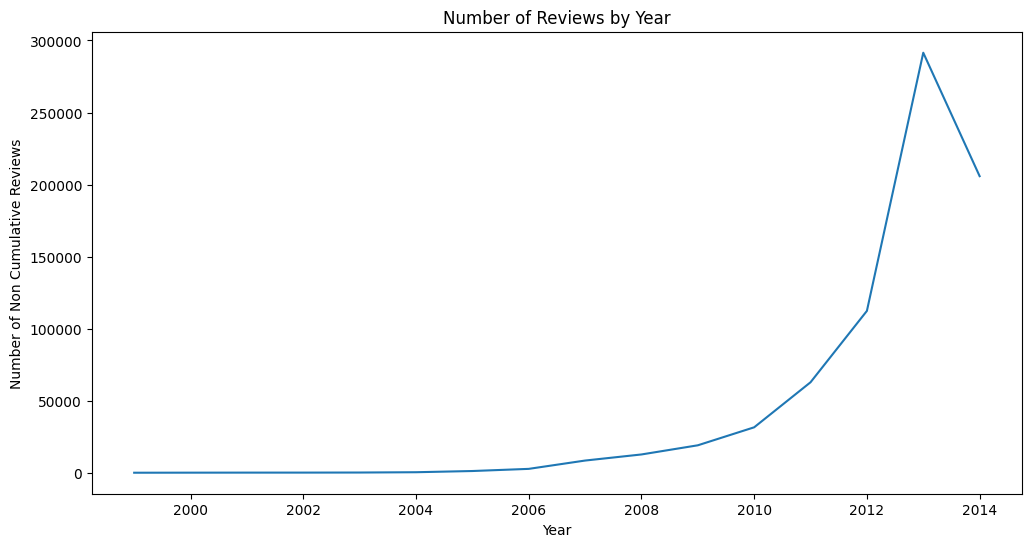

In [ ]:
# plot reviews over time as a line chart
plt.figure(figsize = (12, 6))
df_processed['review_year'].value_counts().sort_index().plot(kind = 'line')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Non Cumulative Reviews')
plt.show()

<Figure size 1000x600 with 0 Axes>

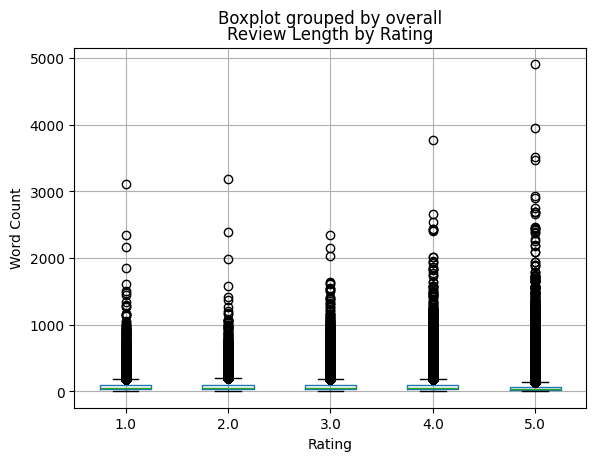

In [ ]:
# creating a boxplot of the number of words on the rating the customer left
# there are a lot of large outliers where customers left very long reviews!
# we will filter out very long reviews later on in the notebook as this will
# take considerable computing resources for our model to train on
plt.figure(figsize = (10, 6))
df_processed.boxplot(column = 'word_count', by = 'overall')
plt.title('Review Length by Rating')
plt.xlabel('Rating')
plt.ylabel('Word Count')
plt.show()

## Model building

In [20]:
# to begin, we will start with defining a few helper classes that will be passed to our IntentClassifier.
# starting with early stopping. This class will automatically stop our training if the validation loss
# in a particular training epoch gets worse than the previous epoch.
# this will hopefully keep our model from getting overfit
class EarlyStopping:
    """
    this class will automatically stop training if the validation loss is worse than the prior epoch

    parameters:
        - patience: the number of epochs to wait before stopping
        - verbose: prints messages about improvements in the validation loss
        - delta: min change in loss to qualify as an improvement
        - path: path to save the checkpoint
        - trace_func: prints a message
    """
    # initializing the parameters
    def __init__(self, patience = 1, verbose = False, delta = 0, path = '/content/drive/MyDrive/DTSA 5511 - Intro to Deep Learning/checkpoint.pt', trace_func = print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    # main method
    def __call__(self, val_loss, model):
        # converting the loss score to a negative number
        score = -val_loss

        # first epoch
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # save epoch with lowest delta
        # initialize early stopping counter
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        # if counter reaches patience, set early_stop
        # if score has improved, save the model and update the best score
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    # function to save the model state and update the validation loss
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [21]:
# now we will create the BiLSTM framework
# this IntentClassifier class will convert the input text into word embeddings
# pass the embeddings into the bi-directional LSTM
# outputs the intent class scores
class IntentClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_classes, dropout=0.3):
        """
        builds and initializes the BiLSTM model

        args:
            - vocab_size: size of the vocabulary
            - embedding_dim: size of each word embedding
            - hidden_dim: number of hidden units
            - n_layers: number of LSTM layers
            - n_classes: number of intent classes (4 in our case)
            - dropout: dropout rate to prevent overfitting
        """
        super().__init__()

        # creates the word embeddings from word indices
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)

        # creating the bi-directional LSTM with the following dimensions:
            # embedding_dim: the size of each word embedding
            # hidden_dim: the nuber of hidden units
            # n_layers: the number of LSTM layers
            # bidirectinoal: makes the LSTM bi-directiona;
            # batch_first: ensures the correct shape
            # dropout: prevents overfitting
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )

        # creating a fully connected layer with our bi-directional framework
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # creating a fully connected output layer
        self.fc = nn.Linear(hidden_dim * 2, n_classes)

        # randomly dropping neurons to prevent overfitting
        self.dropout = nn.Dropout(dropout)

    def attention_net(self, lstm_output, final_hidden):
        """
        implements a attention mechanism to focus on relevant word

        args:
            - lstm_output: output of the LSTM
            - final_hidden: outputting the final state

        returns:
            - attention weighted output
        """

        # fully connected layer pass through
        attention_weights = torch.tanh(self.attention(lstm_output))

        # softmax to convert scores to probabilities
        attention_weights = F.softmax(attention_weights, dim=1)

        # computes weighted sum of LSTM outputs
        attention_output = torch.bmm(lstm_output.transpose(1, 2), attention_weights)

        # final vector
        return attention_output.squeeze(2)

    def forward(self, text, text_lengths):
        """
        forward pass

        args:
            - text: input text tensor
            - text_lengths: length of each sequence

        returns:
            intent class
        """

        # converts indices into embeddings
        embedded = self.dropout(self.embedding(text))

        # converts input into packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first = True, enforce_sorted = False
        )

        # run packed sequence through bi-directional LSTM
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # converts LSTM output back to tensor
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first = True)

        # attention weighted output
        attention_output = self.attention_net(output, hidden)

        # passing through fully connected layer
        predictions = self.fc(attention_output)

        return predictions

In [126]:
# setting our model hyperparameters
vocab_size = len(word2idx)
embedding_dim = 100
hidden_dim = 128
n_layers = 2
n_classes = 4
dropout = 0.3

# creating the model instnace with IntentClassifier
model = IntentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout=dropout
)

In [127]:
# this is the main function that will train our BiLSTM model
# it will also track the acuracy and loss and save the best model with early stopping considered
# and hopefully will avoid overfitting
def train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs, device, patience = 1):
    """
    train the BiLSTM model

    args:
        - model: BiLSTM model
        - train_loader: training data loader
        - val_loader: validation data loader
        - criterion: loss function
        - optimizer: optimizer
        - n_epochs: number of epochs to train
        - device: gpu or nah
        - patience: early stopping patience
    """
    # ensuring we are using GPU
    model = model.to(device)

    # stores loss and accuracy for each epoch
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # use early stopping to prevent overfitting
    early_stopping = EarlyStopping(patience = patience, verbose = True)

    # storing the best validation accuracy
    best_val_acc = 0

    for epoch in range(n_epochs):
        start_time = time.time()

        # training and saving:
            # train_loss: batch loss
            # train_predictions: the model predictions
            # train_labels: ground truth labels
        model.train()
        train_losses = []
        train_predictions = []
        train_labels = []

        # implementing a fancy progress bar
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} / {n_epochs} [Train]')

        # looping through each batch
        for batch in train_pbar:
            text, labels, lengths = batch
            text = text.to(device)
            labels = labels.to(device)
            lengths = lengths.to(device)

            # running forward pass to get predictions and computing loss
            optimizer.zero_grad()
            outputs = model(text, lengths)
            loss = criterion(outputs, labels)

            # running backwards pass to compute gradients
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
            optimizer.step()

            # store the batch loss and converts predictions from tensor to array
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs, 1)
            train_predictions.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # updating the progress bar
            train_pbar.set_postfix({'loss': np.mean(train_losses)})

        # computes training loss and accuracy
        train_loss = np.mean(train_losses)
        train_acc = np.mean(np.array(train_predictions) == np.array(train_labels))

        # to capture validation loss and prediction
        model.eval()
        val_losses = []
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            # display progress bar
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} / {n_epochs} [Val]')

            # loping through validation data
            for batch in val_pbar:
                text, labels, lengths = batch
                text = text.to(device)
                labels = labels.to(device)
                lengths = lengths.to(device)

                # run forward pass and computes loss
                outputs = model(text, lengths)
                loss = criterion(outputs, labels)

                # store predictions and losses
                val_losses.append(loss.item())
                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                # update progress bar
                val_pbar.set_postfix({'loss': np.mean(val_losses)})

        # calculate average validation loss and accuracy
        val_loss = np.mean(val_losses)
        val_acc = np.mean(np.array(val_predictions) == np.array(val_labels))

        # saves model state if validation accuracy is better than last epoch
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
            }, 'best_model.pth')

        # saving training and validation loss
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # printing the epoch time and training/validation loss metrics for the epoch
        time_elapsed = time.time() - start_time
        print(f'\nEpoch {epoch+1} / {n_epochs} completed in {time_elapsed:.0f}s')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # pritn classification report
        intent_labels = ['sizing', 'tech_specs', 'recommendations', 'other']
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_predictions, target_names=intent_labels))
        print('-' * 60)

        # early stopping catch
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return history

In [128]:
# GPU or naw
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# using GPU
model = model.to(device)

# defining CrossEntropy loss function (useful for multi-classification problems)
criterion = nn.CrossEntropyLoss().to(device)

# using Adam optimizer
optimizer = torch.optim.Adam(model.parameters())

In [129]:
# running out model framework with all required parameters
history = train_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    criterion = criterion,
    optimizer = optimizer,
    n_epochs = 10,
    device=device
)

Epoch 1 / 10 [Val]: 100%|██████████| 4680/4680 [00:55<00:00, 83.91it/s, loss=0.118]



Epoch 1 / 10 completed in 638s
Train Loss: 0.2245 | Train Acc: 0.9285
Val Loss: 0.1184 | Val Acc: 0.9679

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.97      0.99     77173
     tech_specs       0.96      0.96      0.96     24641
recommendations       0.93      0.93      0.93     21260
          other       0.92      0.98      0.95     26685

       accuracy                           0.97    149759
      macro avg       0.95      0.96      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
Validation loss decreased (inf --> 0.118365). Saving model ...


Epoch 2 / 10 [Val]: 100%|██████████| 4680/4680 [00:55<00:00, 84.45it/s, loss=0.104]



Epoch 2 / 10 completed in 635s
Train Loss: 0.1163 | Train Acc: 0.9675
Val Loss: 0.1043 | Val Acc: 0.9708

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.98      0.99     77173
     tech_specs       0.97      0.97      0.97     24641
recommendations       0.93      0.95      0.94     21260
          other       0.93      0.98      0.95     26685

       accuracy                           0.97    149759
      macro avg       0.96      0.97      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
Validation loss decreased (0.118365 --> 0.104289). Saving model ...


Epoch 3 / 10 [Val]: 100%|██████████| 4680/4680 [00:56<00:00, 83.53it/s, loss=0.102]



Epoch 3 / 10 completed in 634s
Train Loss: 0.1052 | Train Acc: 0.9706
Val Loss: 0.1020 | Val Acc: 0.9715

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.98      0.99     77173
     tech_specs       0.97      0.97      0.97     24641
recommendations       0.93      0.95      0.94     21260
          other       0.93      0.98      0.95     26685

       accuracy                           0.97    149759
      macro avg       0.96      0.97      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
Validation loss decreased (0.104289 --> 0.102011). Saving model ...


Epoch 4 / 10 [Val]: 100%|██████████| 4680/4680 [00:59<00:00, 78.30it/s, loss=0.101]



Epoch 4 / 10 completed in 656s
Train Loss: 0.1003 | Train Acc: 0.9717
Val Loss: 0.1012 | Val Acc: 0.9719

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.98      0.99     77173
     tech_specs       0.96      0.97      0.97     24641
recommendations       0.93      0.95      0.94     21260
          other       0.94      0.98      0.96     26685

       accuracy                           0.97    149759
      macro avg       0.96      0.97      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
Validation loss decreased (0.102011 --> 0.101227). Saving model ...


Epoch 5 / 10 [Val]: 100%|██████████| 4680/4680 [00:59<00:00, 78.62it/s, loss=0.101]



Epoch 5 / 10 completed in 666s
Train Loss: 0.0972 | Train Acc: 0.9724
Val Loss: 0.1007 | Val Acc: 0.9720

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.98      0.99     77173
     tech_specs       0.97      0.97      0.97     24641
recommendations       0.94      0.95      0.94     21260
          other       0.93      0.98      0.96     26685

       accuracy                           0.97    149759
      macro avg       0.96      0.97      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
Validation loss decreased (0.101227 --> 0.100702). Saving model ...


Epoch 6 / 10 [Val]: 100%|██████████| 4680/4680 [00:58<00:00, 79.62it/s, loss=0.101]



Epoch 6 / 10 completed in 655s
Train Loss: 0.0943 | Train Acc: 0.9731
Val Loss: 0.1011 | Val Acc: 0.9722

Validation Classification Report:
                 precision    recall  f1-score   support

         sizing       1.00      0.98      0.99     77173
     tech_specs       0.97      0.97      0.97     24641
recommendations       0.93      0.95      0.94     21260
          other       0.94      0.98      0.96     26685

       accuracy                           0.97    149759
      macro avg       0.96      0.97      0.96    149759
   weighted avg       0.97      0.97      0.97    149759

------------------------------------------------------------
EarlyStopping counter: 1 out of 1
Early stopping triggered


## Saving/loading the best model

In [131]:
# after training has completed, we will use this function to save our best model to use at a later time (to avoid having to re-train each time)
def save_model(model, optimizer, history, filename = '/content/drive/MyDrive/DTSA 5511 - Intro to Deep Learning/trained_model.pth'):
    """
    save the top trained model along with training history and optimizer

    args:
        - model: trained PyTorch model
        - optimizer: optimizer used for training
        - history: training history dictionary
        - filename: name of the file
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'model_config': model.config if hasattr(model, 'config') else None
    }

    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

In [132]:
# calling our save_model function to re-use later
save_model(model, optimizer, history)

Model saved to /content/drive/MyDrive/DTSA 5511 - Intro to Deep Learning/trained_model.pth


In [3]:
# creating a loading function that will loading the model we had previously saved
# with the same parameters we had previously passed
def load_intent_classifier(model_path, vocab_size, embedding_dim = 100, hidden_dim = 128,
                         n_layers = 2, n_classes = 4, dropout = 0.3):
    """
    load the trained IntentClassifier model

    args:
        - model_path: save path
        - vocab_size: vocab size
        - embedding_dim: word embeddings dimensions
        - hidden_dim: # of hidden unit
        - n_layers: # of LSTM layers
        - n_classes: # of intent classes
        - dropout: preventing overfitting
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # init model with same architecture as previously defined
    model = IntentClassifier(
        vocab_size = vocab_size,
        embedding_dim = embedding_dim,
        hidden_dim = hidden_dim,
        n_layers = n_layers,
        n_classes = n_classes,
        dropout = dropout
    ).to(device)

    # loading the correct checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    return model

In [22]:
# calling the load_intent_classifier from above to use for a prediction
model = load_intent_classifier(
    model_path = '/content/drive/MyDrive/DTSA 5511 - Intro to Deep Learning/trained_model.pth',
    vocab_size = len(word2idx)
)

<ipython-input-3-cc529ccaeb8d>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


### Testing the model

Now with our model saved/loaded, we can use it to predict on a newly unseen text input. Apart from using the accuracy/precision/f1 score, this is a fantastic way to see if the model makes accurate predictions based on what we would expect!

We can create a function to load our model and it's inputs and make a fresh prediction.

In [23]:
def predict_single_text(model, text, word2idx, max_seq_length = 200, device = None):
    """
    predicts the intent class of a text input

    args:
        - model: the IntentClassifier model
        - text: text string
        - word2idx: vocab dictionary
        - max_seq_length: maximum sequence length
        - device: GPU or naw

    returns:
        - predicted_class: predicted intent class
        - class_probabilities: probabilities for each class
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # creating a DF to hold our text input
    df_single = pd.DataFrame({'cleaned_text': [text]})

    # preparing the sequence
    X_tensor, lengths_tensor, _ = prepare_data_for_training(df_single, max_seq_length)
    X_tensor = X_tensor.to(device)
    lengths_tensor = lengths_tensor.to(device)

    # get the prediction
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor, lengths_tensor)
        probabilities = torch.softmax(outputs, dim = 1)
        predicted_class = torch.argmax(outputs, dim = 1)

    return predicted_class.item(), probabilities[0].cpu().numpy()

In [38]:
# Make a new prediction
text = "How does the large size fit? What is the height, length, and width of the front pannel?"
predicted_class, probabilities = predict_single_text(
    model = model,
    text = text,
    word2idx = word2idx
)

In [39]:
# checking the predicted class and the probabilities for each
predicted_class, probabilities

(0, array([0.594193  , 0.15960126, 0.00153587, 0.24466993], dtype=float32))

In [40]:
# readable output
intent_labels = ['sizing', 'tech_specs', 'recommendations', 'other']
predicted_intent = intent_labels[predicted_class]
print(f"Predicted intent: {predicted_intent}")

Predicted intent: sizing


## Conclusion

In conclusion this project implemented a Bidirectional LSTM neural network to automatically classify customer inquirier into three distinct intent categories:

1.  sizing questions
2.  technical specifications
3.  product recommendations

This notebook provides an end to end example from data loading and preprocessing, model implementation, and testing and accuracy scores against our validation dataset.

More specifically here's an outline of the work that was completed.


###Data Preprocessing


- Implemented comprehensive text cleaning and standardization
- Created an extensive vocabulary system
- Developed keyword labeling system for intent classification
- Utilized padding and sequence length standardization for neural network compatibility


###Model Architecture


- Implemented a BiLSTM model with attention mechanism with a:
  - embedding layer for word vector representation
  - bi-directional LSTM layers for context capture
  - attention mechanism on relevant words
  - fully connected layer for final classification


###Training Framework

- Developed dataset and dataloader classes
- Implemented early stopping
- Included model checkpointing to save the best epoch
- Utilized cross-entropy loss and Adam optimizer
- Incorporated dropout for regularization

Overall there were many aspects of the project achieved great results. The model was successful in classifying customer service inquiries across four intent categories, implementing attention mechanisms and early stopping to improve model accuracy. The ability for the top model to be saved/loaded into a new notebook was also included and worked extremely well.

The notebook also demonstrated a reusable preprocessing pipeline that tokenized and standardized text input that was fed into the BiLSTM model. It also developed batch processing and a modular architecture to re-use in other projects.

The outcome was extremely impressive. The model was able to successfully automate customer query routing by providing a probability score for each intent category.

###Future Improvements

Even with the success the model achieved, there are a few areas of future improvements that could be implemented. To start, the input data itself could certainly be expanded to include additional keywords to provide broader initial labeling. Additional data outside of the Amazon Sports and Outdoor could be added to incorporate more diverse customer questions.

Fine-tuning of the model is another area in the proeject that could be improved upn. Additional hyperparameter tuning would result in a more accurate model. Additional model accuracy would better improve the classification of the customers questions and could avoid confusion if the model was implemented.

###Business Value

To reiterate, the automated intent classification system provides key business benefits including reduced response times for customer inquiries, improved routing accuracy, increased the quantity of customer questions that would be able to be handled. This framework could also be extended to offer a purely automated customer service system if additional models were trained to answer each of the three intent categories we have defined. A purely automated customer service system would allow for great cost savings and would reduce customer times to resolution.

In conclusion, this project successfully implemented a BiLSTM model that improved service efficiency that would be a terrific solution for any outdoor retailer with an online store to better serve customers through automated customer service routing.

# Citations

1.   Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016
2.   Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015